# Imports and definitions

In [1]:
from scipy.integrate import trapz
from scipy.stats import poisson, gamma, gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_dist(dist, resolution=100, x=None, figsize=(15,5), ax=None, style='r-', label=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    if x is None:
        x = np.linspace(dist.ppf(1/(resolution*2)), dist.ppf(1 - 1/(resolution*2)), resolution)
    ax.plot(x, dist.pdf(x), style, lw=4, alpha=0.6, label=label)
    plt.legend()
    return ax

In [3]:
def get_gamma_from_moments(mean, std):
    scale = (std ** 2) / mean
    alpha = (mean ** 2) / (std ** 2)
    return gamma(a=alpha, scale=scale)

# Scratch

In [4]:
# Specify mean and std of the gamma you want
mean = 3
std = 2

In [5]:
# Manipulations to give standard (alpha=`shape`, beta=`rate`) and scipy (a=alpha, scale) parameterisations
scale = (std ** 2) / mean
alpha = (mean ** 2) / (std ** 2)
beta = 1 / scale

In [6]:
'''
For Poisson conjugate priors, alpha can be thought of as number of events,
beta as number of time periods observed. 
'''
alpha, beta

(2.25, 0.75)

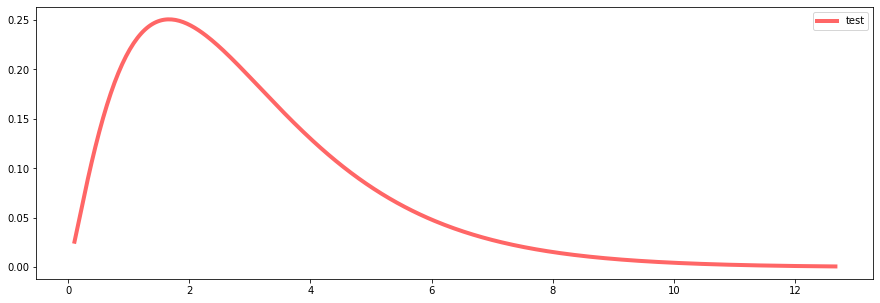

In [7]:
test = gamma(a=alpha, scale=scale, loc=0)
# test = gamma(a=1, scale=10000, loc=0)

plot_dist(test, resolution=400, label='test');

## Check my assumption that likelihood of poisson(k, t) ~ gamma(k+1, t)

c.f. Bernoulli likelihood ~ Beta(pos+1, neg+1)

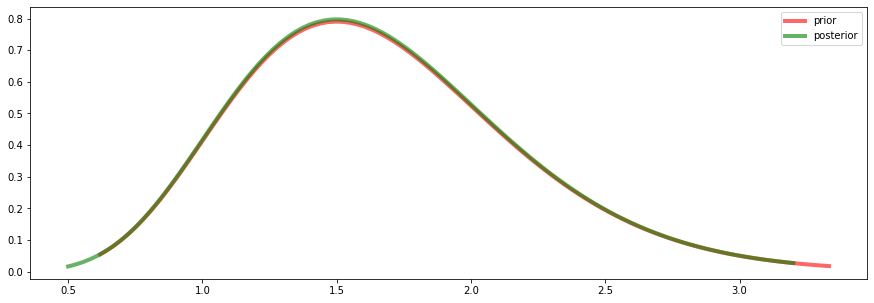

In [9]:
# e.g. manually calculate likelihood for 9 events observed from 6 time_periods
foo = np.linspace(0.5,3.2,100)
bar = [poisson(x * 6).pmf(9) for x in foo]
auc = trapz(bar, foo)
bar_normed = [y/auc for y in bar]

# check that corresponding gamma sits on top of this curve
ax = plot_dist(gamma(a=9+1, scale=1/6), label='prior')
ax.plot(foo, bar_normed, 'g-', lw=4, alpha=0.6, label='posterior')
plt.legend();

# Template for poisson split test analysis

## Define prior over uplift

In [10]:
uplift_prior_mean = 1.5
uplift_prior_std = 0.5

uplift_prior_dist = get_gamma_from_moments(uplift_prior_mean, uplift_prior_std)

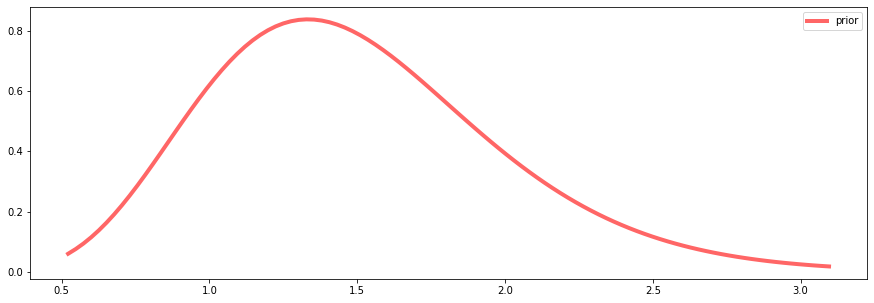

In [11]:
plot_dist(uplift_prior_dist, label='prior');

## Make up some demo data

In [12]:
from collections import namedtuple

In [13]:
Observation = namedtuple('Observation', field_names=('events_observed', 'n_time_periods'))

In [14]:
observed_A_before = Observation(100, 1)
observed_B_before = Observation(80, 1)

observed_A_after = Observation(330, 3)
observed_B_after = Observation(290, 3)

## Calculate likelihoods over underlying rates

In [15]:
def get_likelihood_from_observation(observation):
    shape = observation.events_observed + 1
    scale = 1 / observation.n_time_periods
    likelihood = gamma(a=shape, scale=scale)
    return likelihood

In [17]:
likelihood_A_before = get_likelihood_from_observation(observed_A_before)
likelihood_B_before = get_likelihood_from_observation(observed_B_before)
likelihood_A_after = get_likelihood_from_observation(observed_A_after)
likelihood_B_after = get_likelihood_from_observation(observed_B_after)

## Infer likelihood over the ratio of rates between branches

In [18]:
resolution = 100
pdf_sample_points = np.linspace(1/(resolution*2), 1 - 1/(resolution*2), resolution)

### Likelihood of `rate_B / rate_A` before

In [19]:
A_before_samples = likelihood_A_before.ppf(pdf_sample_points)
B_before_samples = likelihood_B_before.ppf(pdf_sample_points)

ratio_before_samples = [B/A for A in A_before_samples for B in B_before_samples]

ratio_before_likelihood = gaussian_kde(dataset=ratio_before_samples)

### Likelihood of `rate_B / rate_A` after

In [20]:
A_after_samples = likelihood_A_after.ppf(pdf_sample_points)
B_after_samples = likelihood_B_after.ppf(pdf_sample_points)

ratio_after_samples = [B/A for A in A_after_samples for B in B_after_samples]

ratio_after_likelihood = gaussian_kde(dataset=ratio_after_samples)

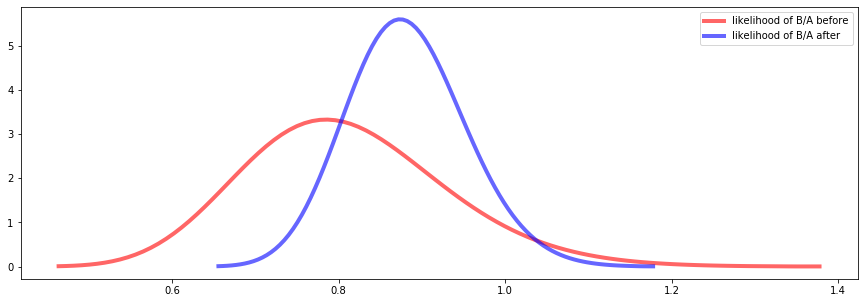

In [21]:
ax = plot_dist(ratio_before_likelihood,
               x = np.linspace(min(ratio_before_samples), max(ratio_before_samples), 100),
               label='likelihood of B/A before')

plot_dist(ratio_after_likelihood,
          x = np.linspace(min(ratio_after_samples), max(ratio_after_samples), 100),
          ax=ax,
          style='b-',
          label='likelihood of B/A after');

## Infer likelihood over the uplift

In [22]:
ratio_after_samples = np.quantile(ratio_after_samples, pdf_sample_points)
ratio_before_samples = np.quantile(ratio_before_samples, pdf_sample_points)

uplift_samples = [ratio_after / ratio_before
                  for ratio_after in ratio_after_samples
                  for ratio_before in ratio_before_samples]

uplift_likelihood = gaussian_kde(dataset=uplift_samples)

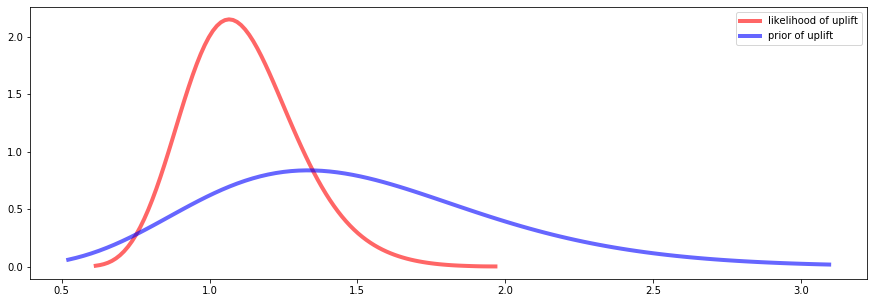

In [23]:
ax = plot_dist(uplift_likelihood,
               x=np.linspace(min(uplift_samples), max(uplift_samples), 100),
               label='likelihood of uplift')
plot_dist(uplift_prior_dist,
          ax=ax,
          style='b-',
          label='prior of uplift');

## Combine likelihood with prior to give posterior

In [24]:
evaluation_range = np.linspace(min(uplift_samples), max(uplift_samples), 1000)
posterior_not_normed = [uplift_likelihood.pdf(x)[0] * uplift_prior_dist.pdf(x) for x in evaluation_range]

In [25]:
auc = trapz(posterior_not_normed, evaluation_range)
posterior_normed = [y/auc for y in posterior_not_normed]

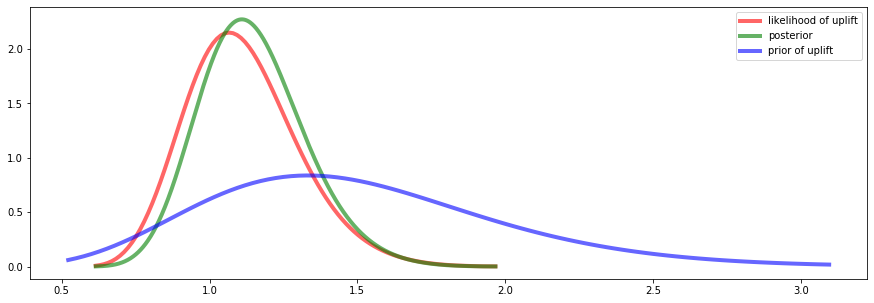

In [26]:
ax = plot_dist(uplift_likelihood,
               x=np.linspace(min(uplift_samples), max(uplift_samples), 100),
               label='likelihood of uplift')

ax.plot(evaluation_range, posterior_normed, 'g-', lw=4, alpha=0.6, label='posterior')

plot_dist(uplift_prior_dist,
          ax=ax,
          style='b-',
          label='prior of uplift');

## Calculate posterior mean to give expected value of uplift

In [27]:
posterior_mean = np.dot(evaluation_range, posterior_normed) / sum(posterior_normed)
posterior_mean

1.1473043272587304